In [1]:
#BTP

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd /content/drive/MyDrive

/content/drive/MyDrive


In [4]:
%pwd

'/content/drive/MyDrive'

In [ ]:
#!unzip "/content/drive/MyDrive/MELD/train_sent_emo.csv.zip" -d "/content/drive/MyDrive/MELD/"

In [5]:
!pip install transformers
!pip install pytorch-lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.8/294.8 kB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 46.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 50.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 727.7/727.7 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 764.8/764.8 kB 10.2 MB/s eta 0:00:00


In [6]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split

import copy
from tqdm import tqdm

from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 8, 6

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [43]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
train_path = '/content/drive/MyDrive/MELD/train_sent_emo.csv'
test_path = '/content/drive/MyDrive/MELD/test_sent_emo.csv'
val_path = '/content/drive/MyDrive/MELD/dev_sent_emo.csv'

In [8]:
train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)
val_data = pd.read_csv(val_path)

In [9]:
train_data.head()

,Sr No.,Utterance,Speaker,Emotion,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,EndTime
0,1,also I was the point person on my companys tr...,Chandler,neutral,neutral,0,0,8,21,"00:16:16,059","00:16:21,731"
1,2,You mustve had your hands full.,The Interviewer,neutral,neutral,0,1,8,21,"00:16:21,940","00:16:23,442"
2,3,That I did. That I did.,Chandler,neutral,neutral,0,2,8,21,"00:16:23,442","00:16:26,389"
3,4,So lets talk a little bit about your duties.,The Interviewer,neutral,neutral,0,3,8,21,"00:16:26,820","00:16:29,572"
4,5,My duties? All right.,Chandler,surprise,positive,0,4,8,21,"00:16:34,452","00:16:40,917"


In [10]:
test_data.head()

,Sr No.,Utterance,Speaker,Emotion,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,EndTime
0,1,Why do all youre coffee mugs have numbers on ...,Mark,surprise,positive,0,0,3,19,"00:14:38,127","00:14:40,378"
1,2,Oh. Thats so Monica can keep track. That way ...,Rachel,anger,negative,0,1,3,19,"00:14:40,629","00:14:47,385"
2,3,Y'know what?,Rachel,neutral,neutral,0,2,3,19,"00:14:56,353","00:14:57,520"
3,19,"Come on, Lydia, you can do it.",Joey,neutral,neutral,1,0,1,23,"0:10:44,769","0:10:46,146"
4,20,Push!,Joey,joy,positive,1,1,1,23,"0:10:46,146","0:10:46,833"


In [11]:
val_data.head()

,Sr No.,Utterance,Speaker,Emotion,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,EndTime
0,1,"Oh my God, hes lost it. Hes totally lost it.",Phoebe,sadness,negative,0,0,4,7,"00:20:57,256","00:21:00,049"
1,2,What?,Monica,surprise,negative,0,1,4,7,"00:21:01,927","00:21:03,261"
2,3,"Or! Or, we could go to the bank, close our acc...",Ross,neutral,neutral,1,0,4,4,"00:12:24,660","00:12:30,915"
3,4,Youre a genius!,Chandler,joy,positive,1,1,4,4,"00:12:32,334","00:12:33,960"
4,5,"Aww, man, now we wont be bank buddies!",Joey,sadness,negative,1,2,4,4,"00:12:34,211","00:12:37,505"


In [12]:
train_data.shape, test_data.shape, val_data.shape

((9989, 11), (2610, 11), (1109, 11))

In [13]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9989 entries, 0 to 9988
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Sr No.        9989 non-null   int64 
 1   Utterance     9989 non-null   object
 2   Speaker       9989 non-null   object
 3   Emotion       9989 non-null   object
 4   Sentiment     9989 non-null   object
 5   Dialogue_ID   9989 non-null   int64 
 6   Utterance_ID  9989 non-null   int64 
 7   Season        9989 non-null   int64 
 8   Episode       9989 non-null   int64 
 9   StartTime     9989 non-null   object
 10  EndTime       9989 non-null   object
dtypes: int64(5), object(6)
memory usage: 858.6+ KB


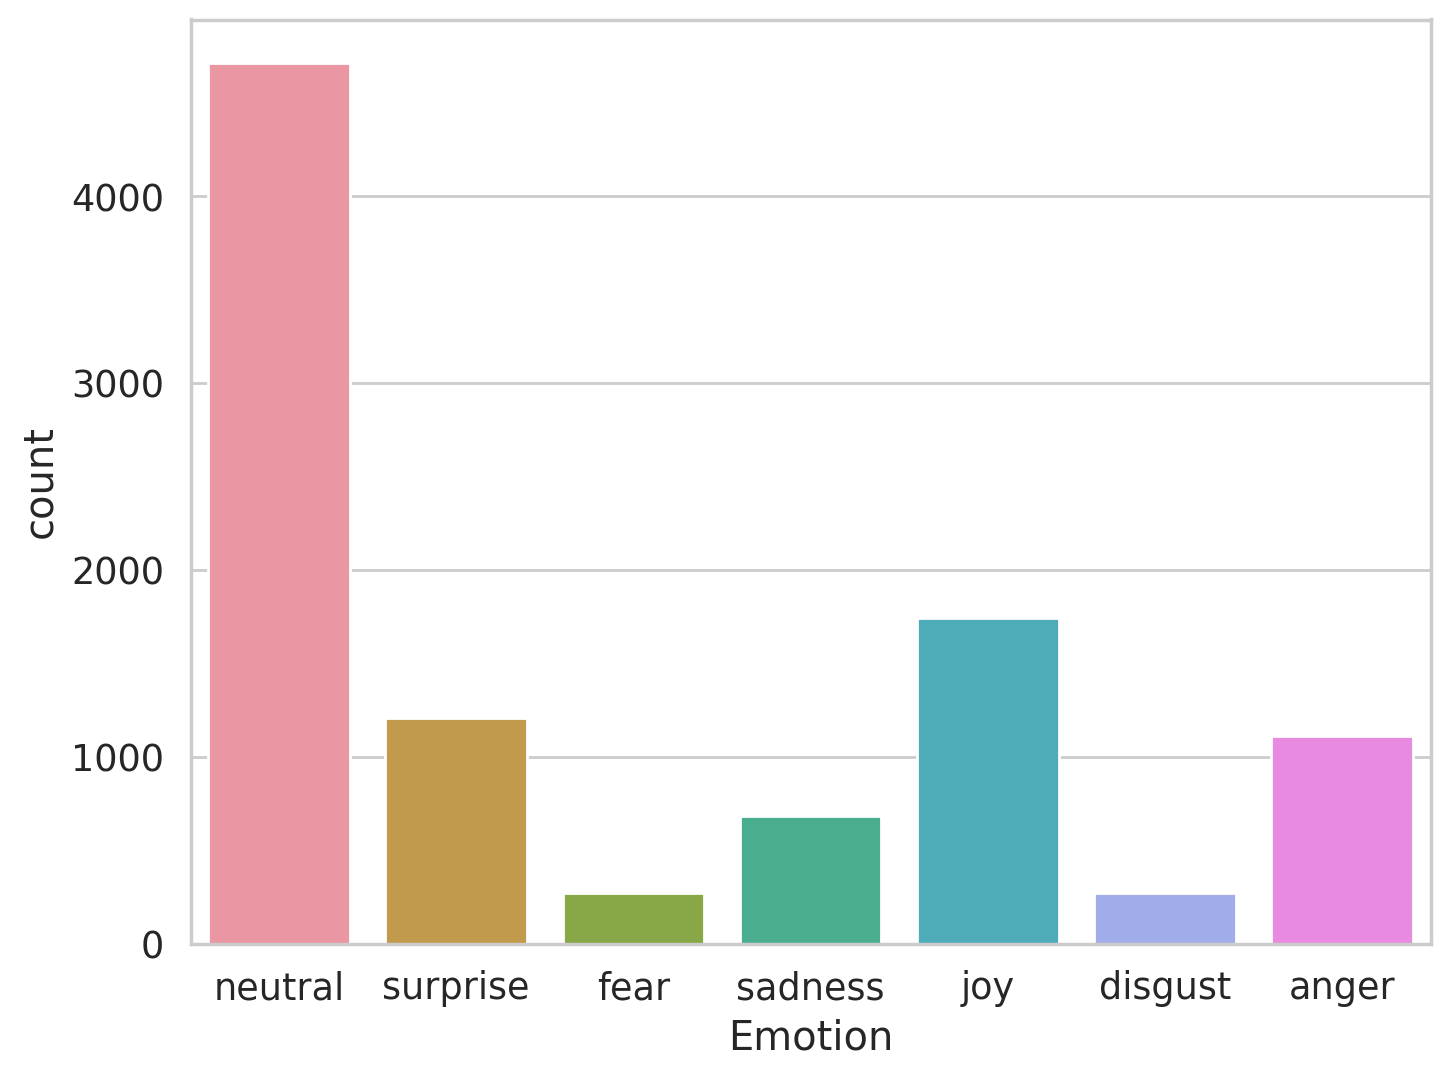

In [14]:
ax = sns.countplot(x="Emotion", data=train_data)

In [15]:
# anger, disgust, fear, joy, sadness, surprise, and neutral

def to_score(emotion):

  if emotion == 'anger':
    return 0
  elif emotion == 'disgust':
    return 1
  elif emotion == 'fear':
    return 2
  elif emotion == 'joy':
    return 3
  elif emotion == 'sadness':
    return 4
  elif emotion == 'surprise':
    return 5
  elif emotion == 'neutral':
    return 6

In [16]:
train_data['emo_label'] = train_data.Emotion.apply(to_score)
test_data['emo_label'] = test_data.Emotion.apply(to_score)
val_data['emo_label'] = val_data.Emotion.apply(to_score)

In [17]:
class_names = ['anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'neutral']

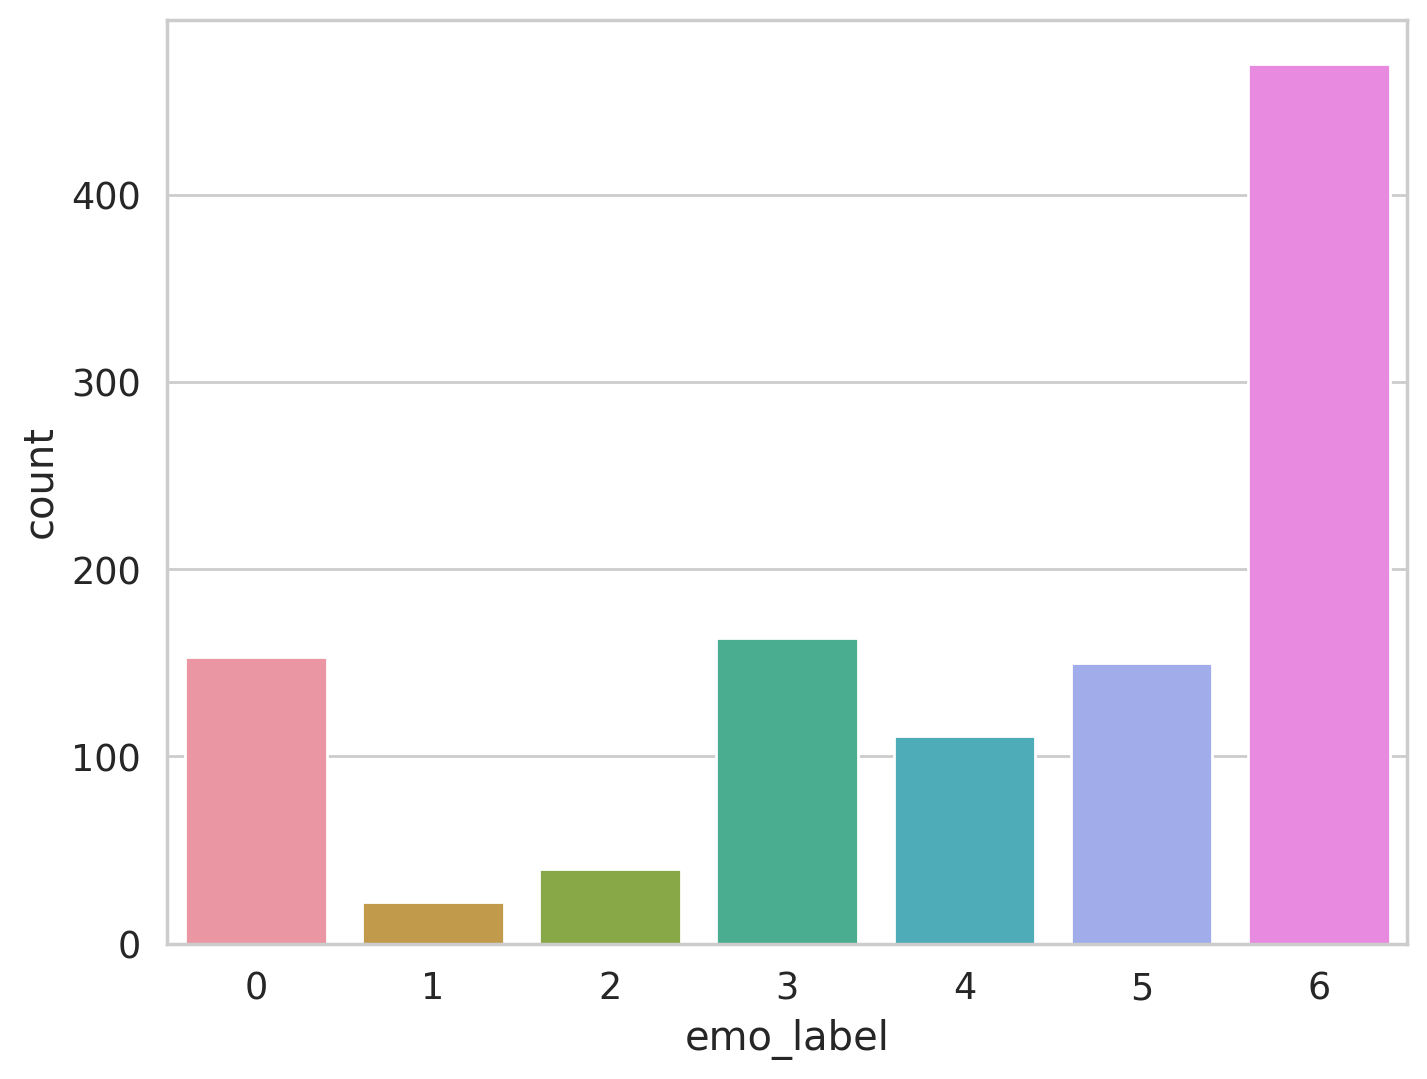

In [18]:
ax = sns.countplot(x="emo_label", data=val_data)

### Using Tokenizer

In [19]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [20]:
sample_txt = 'When was I last outside? I am stuck at home for 2 weeks.'

In [21]:
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: When was I last outside? I am stuck at home for 2 weeks.
   Tokens: ['when', 'was', 'i', 'last', 'outside', '?', 'i', 'am', 'stuck', 'at', 'home', 'for', '2', 'weeks', '.']
Token IDs: [2043, 2001, 1045, 2197, 2648, 1029, 1045, 2572, 5881, 2012, 2188, 2005, 1016, 3134, 1012]


In [22]:
tokenizer.sep_token, tokenizer.sep_token_id, tokenizer.cls_token, tokenizer.cls_token_id

('[SEP]', 102, '[CLS]', 101)

In [23]:
tokenizer.pad_token, tokenizer.pad_token_id, tokenizer.unk_token, tokenizer.unk_token_id

('[PAD]', 0, '[UNK]', 100)

In [24]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=50,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  padding='max_length',
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)
encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [25]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

50


tensor([ 101, 2043, 2001, 1045, 2197, 2648, 1029, 1045, 2572, 5881, 2012, 2188,
        2005, 1016, 3134, 1012,  102,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0])

In [26]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask'][0]

50


tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0])

In [27]:
print(tokenizer.convert_ids_to_tokens(encoding['input_ids'][0]))

['[CLS]', 'when', 'was', 'i', 'last', 'outside', '?', 'i', 'am', 'stuck', 'at', 'home', 'for', '2', 'weeks', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


In [28]:
token_lens = []
for txt in train_data.Utterance:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


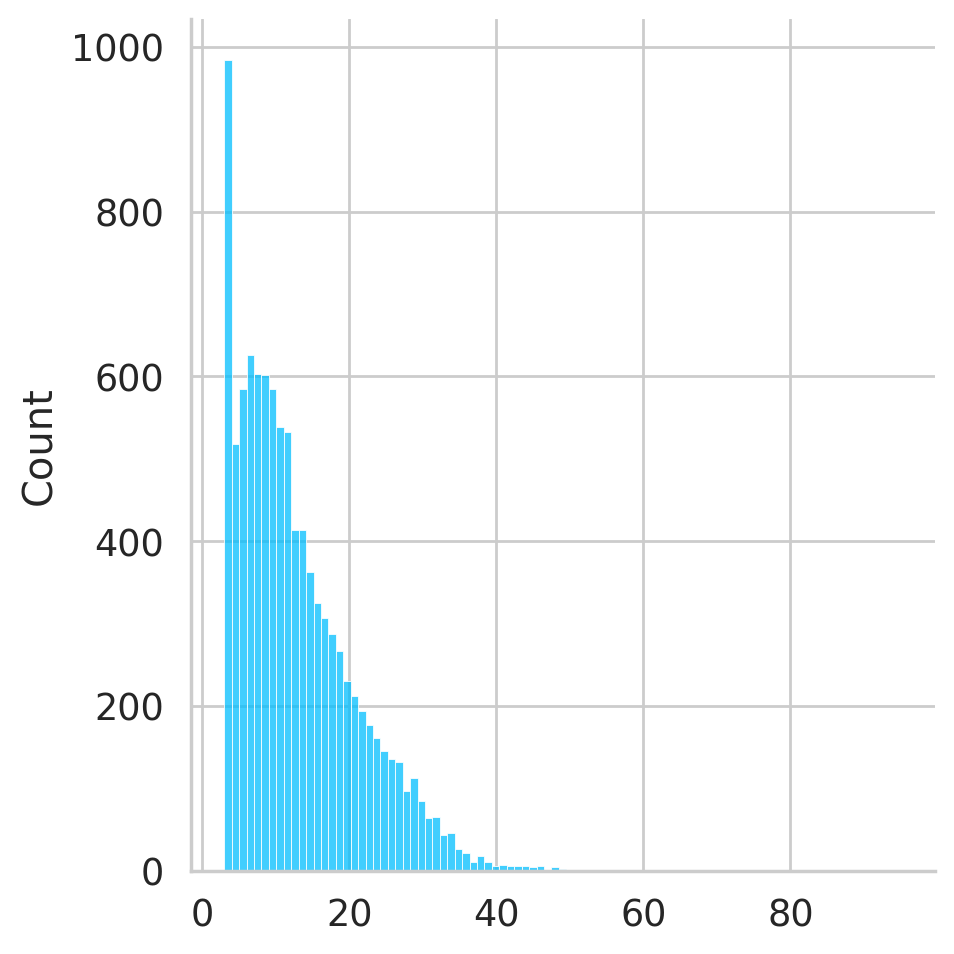

In [29]:
sns.displot(token_lens)

### Preprocessing the DATA

In [30]:
class EmotionDataset(Dataset):
  def __init__(self, utterances, targets, tokenizer, max_len):
    self.utterances = utterances  # utterances is the csv file
    self.targets = targets        # targets are the emotions
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.utterances)

  def __getitem__(self, item):
    utter = str(self.utterances[item])
    emo = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      utter,
      add_special_tokens=True,
      max_length=self.max_len,
      truncation=True,
      return_token_type_ids=False,
      padding='max_length',
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'utter_text': utter,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(emo, dtype=torch.long)
    }

In [31]:
MAX_LEN = 80
BATCH_SIZE = 8
EPOCHS = 10

In [32]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = EmotionDataset(
    utterances=df.Utterance.to_numpy(),
    targets=df.emo_label.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [33]:
train_data_loader = create_data_loader(train_data, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(val_data, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(test_data, tokenizer, MAX_LEN, BATCH_SIZE)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [34]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['utter_text', 'input_ids', 'attention_mask', 'targets'])

In [35]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)
data['utter_text']

torch.Size([8, 80])
torch.Size([8, 80])
torch.Size([8])


['also I was the point person on my company\x92s transition from the KL-5 to GR-6 system.',
 'You must\x92ve had your hands full.',
 'That I did. That I did.',
 'So let\x92s talk a little bit about your duties.',
 'My duties?  All right.',
 'Now you\x92ll be heading a whole division, so you\x92ll have a lot of duties.',
 'I see.',
 'But there\x92ll be perhaps 30 people under you so you can dump a certain amount on them.']

### Running BERT model on the sample_txt

In [36]:
PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'

In [37]:
bert_model = BertModel.from_pretrained('bert-base-uncased')

In [38]:
outputs = bert_model(
  input_ids=encoding['input_ids'],
  attention_mask=encoding['attention_mask']
)

last_hidden_state = outputs.last_hidden_state
pooled_output = outputs.pooler_output

In [39]:
last_hidden_state.shape

torch.Size([1, 50, 768])

In [40]:
pooled_output.shape

torch.Size([1, 768])

In [41]:
bert_model.config.hidden_size

768

### Testing for one instance of our TRAIN DATA

In [42]:
class TeacherClassifier(nn.Module):

  def __init__(self, n_classes):
    super(TeacherClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    self.softmax = nn.Softmax(dim=1)
    self.tanh = nn.Tanh()

  def forward(self, input_ids, attention_mask):
    outputs = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    last_hidden_state = outputs.last_hidden_state
    pooled_output = outputs.pooler_output

    output = self.out(pooled_output)
    logits = self.tanh(output)
    dropout_logits = self.drop(logits)
    probabilities = self.softmax(dropout_logits)
    return probabilities

In [44]:
model = TeacherClassifier(len(class_names))
model = model.to(device)

In [45]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape)

torch.Size([8, 80])
torch.Size([8, 80])


In [46]:
model(input_ids, attention_mask)

tensor([[0.0920, 0.0980, 0.1522, 0.1041, 0.3973, 0.0794, 0.0769],
        [0.1359, 0.1004, 0.1117, 0.1090, 0.3981, 0.0630, 0.0818],
        [0.1320, 0.0955, 0.1246, 0.1320, 0.3693, 0.0703, 0.0763],
        [0.0690, 0.0840, 0.1198, 0.1198, 0.3678, 0.1198, 0.1198],
        [0.0892, 0.1276, 0.1387, 0.1060, 0.3405, 0.0705, 0.1276],
        [0.1169, 0.1220, 0.1488, 0.1748, 0.1748, 0.0878, 0.1748],
        [0.1193, 0.0895, 0.1193, 0.0985, 0.3347, 0.1193, 0.1193],
        [0.0918, 0.1325, 0.1168, 0.1132, 0.4018, 0.0669, 0.0770]],
       device='cuda:0', grad_fn=<SoftmaxBackward0>)

### TRAINING

In [50]:
optimizer = AdamW(model.parameters(), lr=9e-6, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

## Helper Functions

In [51]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()
  losses = []
  correct_predictions = 0

  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)
    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)
    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [52]:
def eval_model(model, data_loader, loss_fn, device, n_examples):

  model = model.eval()
  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)
      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [53]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(train_data)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(val_data)
  )
  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)

  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state_2.bin')
    best_accuracy = val_acc

Epoch 1/10
----------
Train loss 1.786196163408846 accuracy 0.4383822204424867
Val   loss 1.7561913711561574 accuracy 0.5770964833183048

Epoch 2/10
----------
Train loss 1.7513642940070746 accuracy 0.5044549003904295
Val   loss 1.745431929183521 accuracy 0.6005410279531109

Epoch 3/10
----------
Train loss 1.73545103105571 accuracy 0.533086395034538
Val   loss 1.7418293875756024 accuracy 0.6068530207394048

Epoch 4/10
----------
Train loss 1.7271330848133402 accuracy 0.5474021423565922
Val   loss 1.7424953850053198 accuracy 0.60595130748422

Epoch 5/10
----------
Train loss 1.717591446528347 accuracy 0.563920312343578
Val   loss 1.7445010804443908 accuracy 0.6014427412082958

Epoch 6/10
----------
Train loss 1.7146789211574032 accuracy 0.5699269196115727
Val   loss 1.7373664387696082 accuracy 0.6122633002705139

Epoch 7/10
----------
Train loss 1.7100714987234844 accuracy 0.5778356191810992
Val   loss 1.7390555211965986 accuracy 0.611361587015329

Epoch 8/10
----------
Train loss 1.70

In [54]:
model = TeacherClassifier(len(class_names))
model.load_state_dict(torch.load('best_model_state_2.bin'))
model = model.to(device)

### EVALUATION


In [55]:
def get_predictions(model, data_loader):

  model = model.eval()

  utter_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["utter_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )

      _, preds = torch.max(outputs, dim=1)

      utter_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return utter_texts, predictions, prediction_probs, real_values

In [58]:
test_acc, test_loss  = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(test_data)
)

print(f'Test   loss {val_loss} accuracy {val_acc}')

Test   loss 1.7356825346569362 accuracy 0.623985572587917


In [59]:
y_utter_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [60]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

       anger       0.50      0.39      0.44       345
     disgust       0.00      0.00      0.00        68
        fear       0.00      0.00      0.00        50
         joy       0.60      0.58      0.59       402
     sadness       0.42      0.22      0.29       208
    surprise       0.51      0.62      0.56       281
     neutral       0.72      0.86      0.78      1256

    accuracy                           0.64      2610
   macro avg       0.39      0.38      0.38      2610
weighted avg       0.59      0.64      0.61      2610



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [62]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True Emotion')
  plt.xlabel('Predicted Emotion');

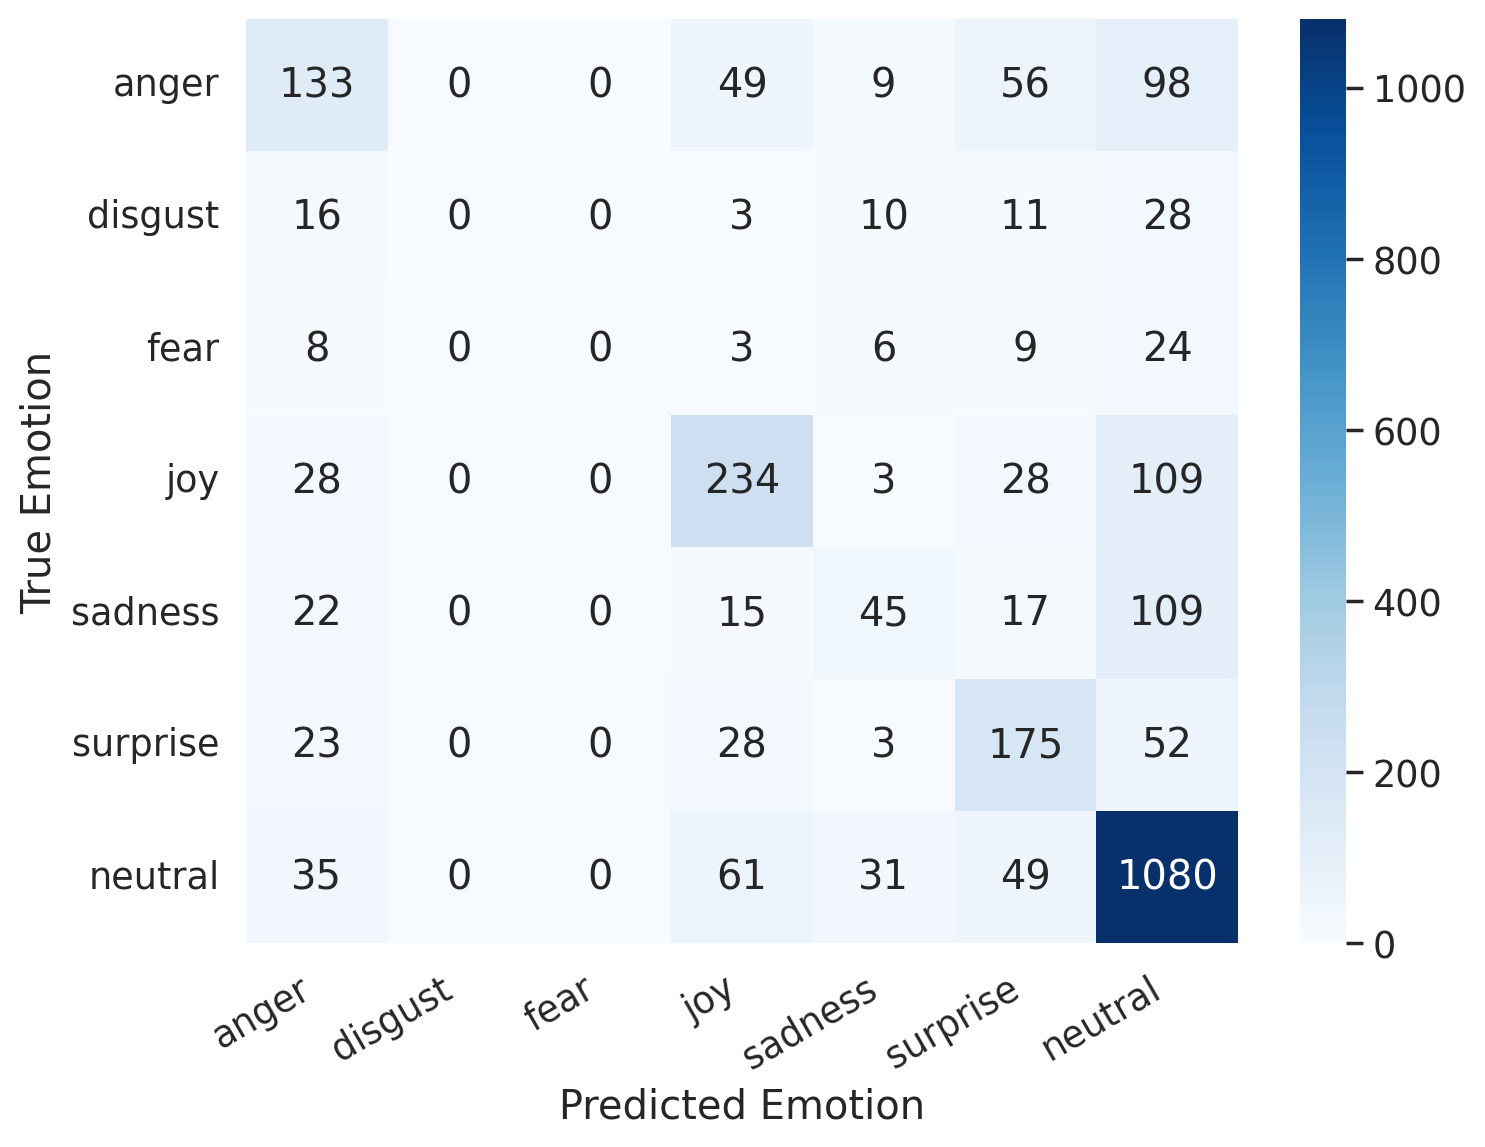

In [63]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [76]:
idx = 233
utter_text = y_utter_texts[idx]
true_emotion = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

In [77]:
print("\n".join(wrap(utter_text)))
print()
print(f'True Emotion: {class_names[true_emotion]}')

Ow!!

True Emotion: anger


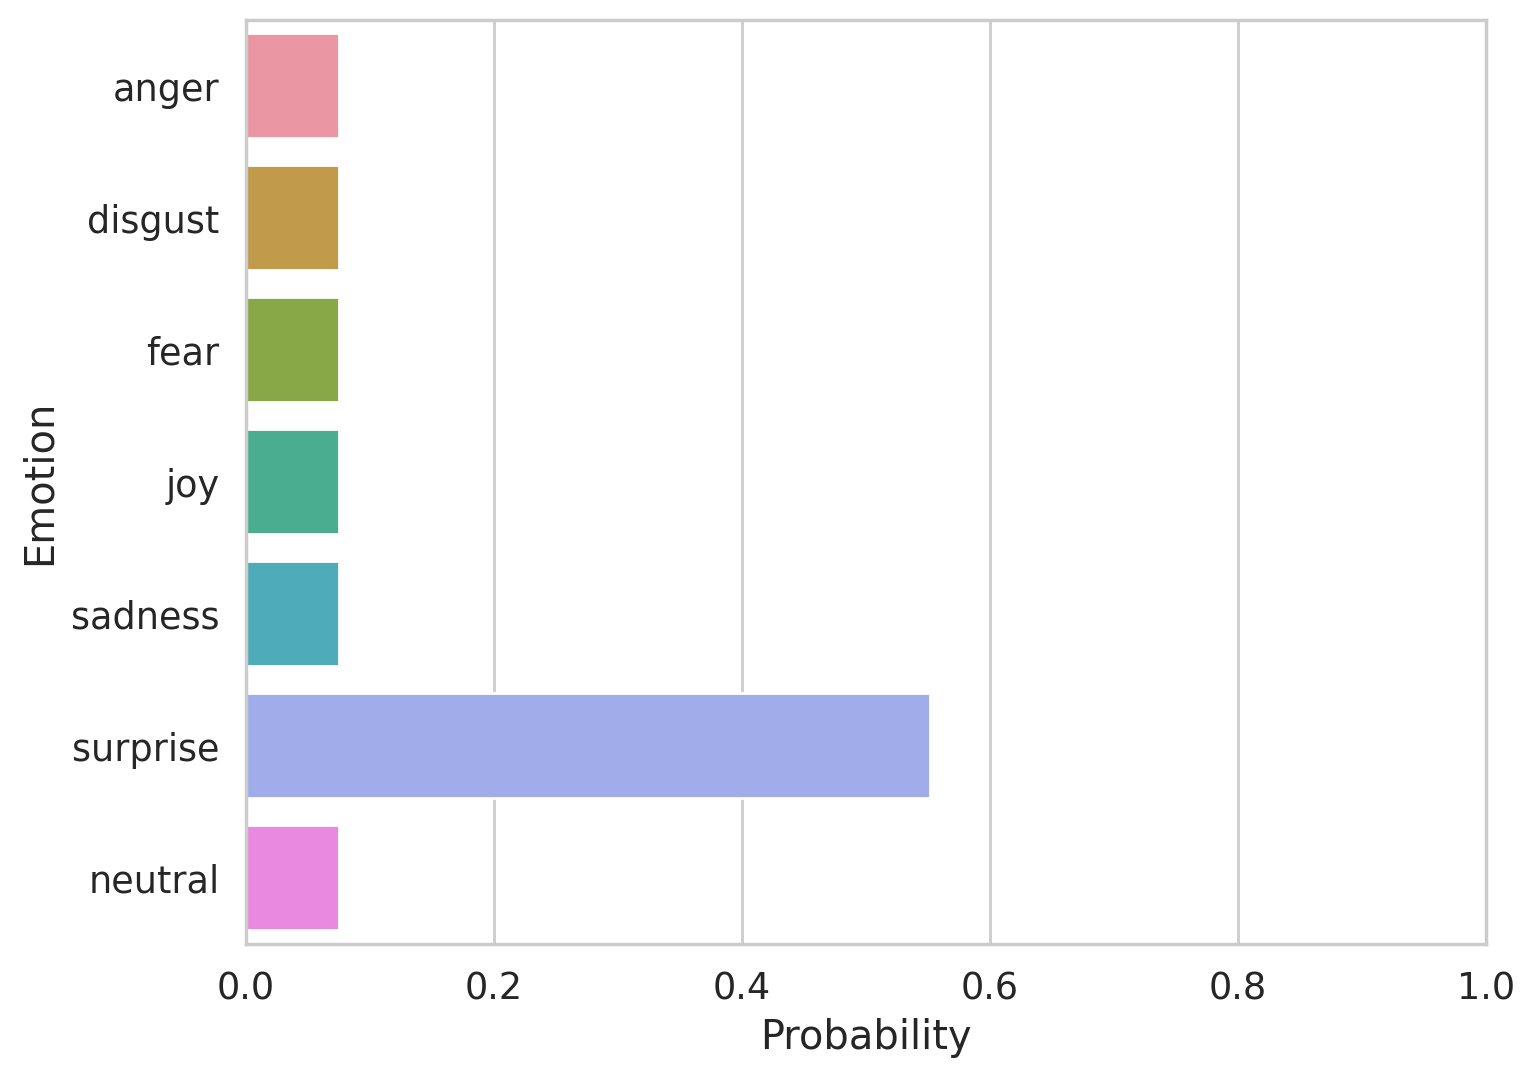

In [78]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('Emotion')
plt.xlabel('Probability')
plt.xlim([0, 1]);

In [80]:
utter_text = "I love completing my todos! Best app ever!!!"

In [81]:
encoded_review = tokenizer.encode_plus(
  utter_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  truncation=True,
  padding='max_length',
  return_attention_mask=True,
  return_tensors='pt',
)

In [83]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Utter text: {utter_text}')
print(f'Emotion   : {class_names[prediction]}')

Utter text: I love completing my todos! Best app ever!!!
Emotion   : joy
